In [1]:
import numpy as np
from matplotlib import pyplot as plt
from collections import namedtuple

# Analysis of Project

Below is some classes and functions setting everything up:
* We have a class `ProblemInstance` representing an instance of the problem
* A function `gen_problem` that generates a problem instance
* Two distributions, `uniform_distribution` and `bad_distribution`



In [2]:
# an instance of a problem
class ProblemInstance():
    
    def __init__(self, num_vertices, num_experts, correctness, expert_opinions, bot_locations):
        self.num_vertices = num_vertices
        self.num_experts = num_experts
        self.correctness = correctness
        self.expert_opinions = expert_opinions
        self.bot_locations = bot_locations
    
    # get a random untested loc
    def next_loc(self, tested_locs):
        verts = set(range(0, self.num_vertices))
        tested_locs = set(tested_locs)
        remaining = np.asarray(list(verts - tested_locs))
        if len(remaining) == 0:
            raise ValueError('cannot sample next loc!')
        return np.random.choice(remaining)
        
    def __repr__(self):
        locs = ' '.join([str(x) for x in self.bot_locations])
        ops = '\n'
        for i in range(self.num_experts):
            ops += '{:.2f} '.format(self.correctness[i])
            ops += ''.join(['Y' if x else 'N' for x in self.expert_opinions[i]])
            ops += '\n'
        s = 'PI({}, {}, [{}], {})'.format(self.num_vertices, self.num_experts, locs, ops)
        return s
        
def uniform_distribution():
    return np.random.uniform(0.5, 1)

def bad_distribution():
    return np.random.uniform(0.5, 0.8)

def beta_distribution():
    return 1 - np.random.beta(4, 2)/2
        
def gen_problem(n=100, k=10, student_correctness=uniform_distribution):
    bot_locations = np.random.choice(100, 5, replace=False)
    expert_opinions = {}
    correctness = {}
    for i in range(k):
        # get student correctness
        alpha = student_correctness()
        correctness[i] = alpha
        num_vertices_correct = int(alpha * n)
        # sample the correct locations
        correct_locations = np.random.choice(n, num_vertices_correct, replace=False)
        
        # build the student opinions
        opinions = []
        for j in range(n):
            b = (j in bot_locations)
            if j in correct_locations:
                opinions.append(b)
            else:
                opinions.append(not b)
        expert_opinions[i] = opinions
        
    return ProblemInstance(n, k, correctness, expert_opinions, bot_locations)

# Implementing Multiplicative weights

* The `most_likely` function takes an instance and the expert opinions, along with weights assigned to each experts, and sorts the untested locations in descending order of which is most likely
* `multiplicative_weights` implements running multiplicative weights with all student opinions, and constantly picking the next most confident vertex based on weight.
* `random_sampling` implements a strategy that looks at vertices in random order, just as a counter-balance

In [3]:
# using the given weights vector, find the most confident locations
def most_likely(p, weights, tested_locs):
    confidences = []
    for loc in range(p.num_vertices):
        if loc not in tested_locs:
            confidence = 0
            for i in range(p.num_experts):
                if p.expert_opinions[i][loc]:
                    confidence += weights[i]
            confidences.append((loc, confidence))
    confidences = sorted(confidences, key= lambda x: -x[1])
#     print(confidences)
    return [k[0] for k in confidences]

# run multiplicative weights on p with value eps, to discover bots as quickly as possible
def multiplicative_weights(p, eps=0.5):
    k = p.num_experts
    discovered_locs = []
    tested_locs = []
    weights = np.repeat(1.0, k)
    
    while len(discovered_locs) < len(p.bot_locations):
#         print(weights)
        loc = most_likely(p, weights, tested_locs)[0]
        has_bot = loc in p.bot_locations
        for i in range(k):
            if has_bot != p.expert_opinions[i][loc]:
                # weight update!
                weights[i] = weights[i] * (1 - eps)
        if has_bot:
            discovered_locs.append(loc)
        tested_locs.append(loc)
    
    return len(tested_locs)

# completely random sampler
def random_sampling(p):
    # sample a random order
    order = np.random.choice(p.num_vertices, p.num_vertices, replace=False)
    discovered_locs = []
    tested_locs = 0
    while len(discovered_locs) < len(p.bot_locations):
        if order[tested_locs] in p.bot_locations:
            discovered_locs.append(order[tested_locs])
        tested_locs += 1
    return tested_locs

def majority_vote(p):
    k = p.num_experts
    weights = np.repeat(1.0, k)
    order = most_likely(p, weights, [])
    discovered_locs = []
    tested_locs = 0
    while len(discovered_locs) < len(p.bot_locations):
        if order[tested_locs] in p.bot_locations:
            discovered_locs.append(order[tested_locs])
        tested_locs += 1
    return tested_locs

# Input Generation

This is kept deterministic with the seed. We generate 1000 random inputs with student correctness as $\alpha \sim [0.5, 1]$, and then also with $\alpha \sim (1 - \beta(4, 2))$ as in the project inputs.

In [4]:
def gen_problems(no=1000, correctness=uniform_distribution):
    np.random.seed(171)
    problems = []
    for i in range(no):
        problems.append(gen_problem(student_correctness=correctness))
    return problems

In [5]:
# WARNING: this cell takes a long time to run
unif_dataset = gen_problems(correctness=uniform_distribution)
beta_dataset = gen_problems(correctness=beta_distribution)

# Evaluation/Hyperparameter Tuning

Fold evaluation and hyperparameter tuning of $\epsilon$ for MW into one. This is not strictly speaking _good practice_, but it gives us a good idea of what epsilon to use for MW.

First, we evaluate using the uniform dataset.

In [6]:
def eval_mw(eps, dataset):
    N = len(dataset)
    data = np.zeros((len(eps), N), dtype=int)
    for i in range(N):
        p = dataset[i]
        for j in range(len(eps)):
            data[j][i] = multiplicative_weights(p, eps[j])
    return data

def eval_fixed(dataset, strategy):
    N = len(dataset)
    data = np.zeros(N, dtype=int)
    for i in range(N):
        data[i] = strategy(dataset[i])
    return data

eps = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

In [7]:
# WARNING: this cell takes a long time to run
unif_dataset_mw_results = eval_mw(eps, unif_dataset)

# Hyperparameter tuning of $\epsilon$ for MW

We first plot the expected time to find all the bots as a function of $\epsilon$, to see what the best value is. Appears to be $\epsilon \approx 0.4$, although really anything that actually uses expert opinions does pretty well because the experts are so good here.

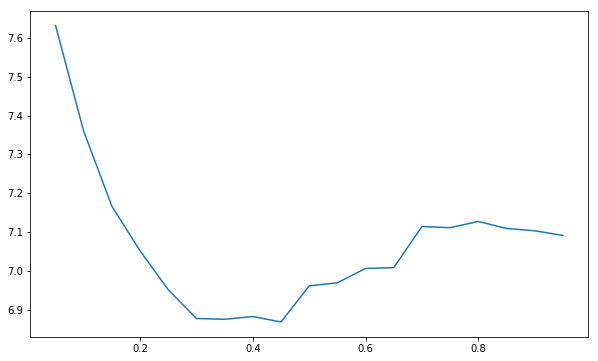

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(eps, np.mean(unif_dataset_mw_results, axis=1))
plt.show()

And just to observe, the distribution is really concentrated around 5. Because the experts are so good, we almost immediately find the bots, because our first few choices work almost all the time and we quickly discover who isn't good, making the remaining choices almost perfect. As a sanity check, we can see that $\epsilon=0.15$ performs marginally worse.

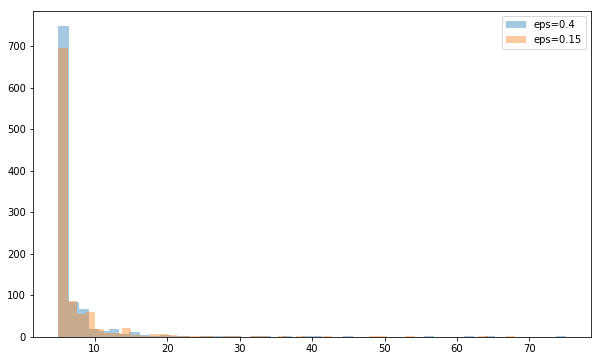

In [9]:
plt.figure(figsize=(10, 6))
for i in [7, 2]:
    plt.hist(unif_dataset_mw_results[i], bins=50, label='eps={}'.format(eps[i]), alpha=0.4)
plt.legend(loc='upper right')
plt.show()

# What is our beta distribution?

Let's look at the distribution of correctness as it was done on the project. We can see that it's heavily biased towards incorrect students, unlike the uniform distribution. This means that in general, really good students are very rare. Let's see what happens with this dataset.

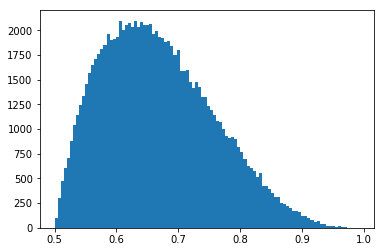

In [10]:
b = 1 - (np.random.beta(4, 2, 100000))/2
# plt.figure(figsize=(10, 6))
plt.hist(b, bins=100)
plt.show()

In [11]:
# WARNING: this cell takes a REALLY LONG while to run
beta_dataset_mw_results = eval_mw(eps, beta_dataset)

In [12]:
beta_dataset_random_results = eval_fixed(beta_dataset, random_sampling)
beta_dataset_mv_results = eval_fixed(beta_dataset, majority_vote)

There's a clear winner in terms of performance with $\epsilon \approx 0.15$.

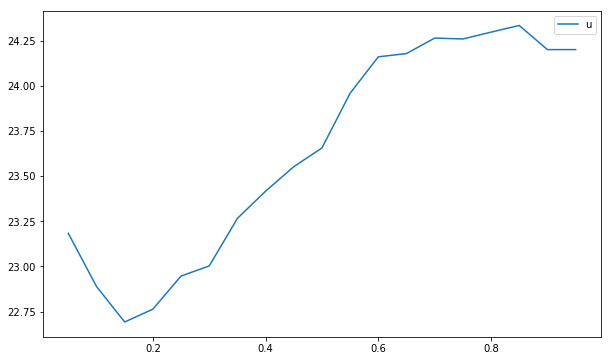

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(eps, np.mean(beta_dataset_mw_results, axis=1), label='MW')
plt.legend('upper right')
plt.show()

And as we can see, it's significantly harder to find the bots now. There's still many instances where we can do it in under 20 tries, but they are much less frequent than with the uniform distribution. As another sanity check, we compare with a completely random strategy, which ends up doing exteremely poorly (because we need to find all the bots, in expectation the maximum of their locations in a random order will be quite large). If we compare with the majority vote strategy, then we see that MW also performs better than ignoring student correctness.

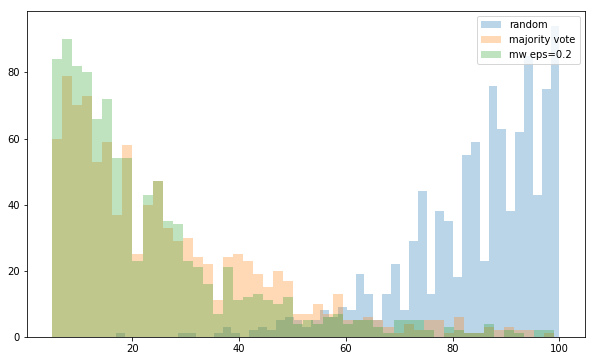

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(beta_dataset_random_results, bins=50, label='random'.format(eps[i]), alpha=0.3)
plt.hist(beta_dataset_mv_results, bins=50, label='majority vote'.format(eps[i]), alpha=0.3)
for i in [3]:
    plt.hist(beta_dataset_mw_results[i], bins=50, label='mw eps={}'.format(eps[i]), alpha=0.3)
plt.legend(loc='upper right')
plt.show()

# Comparing with a Model-Based Solver

The big question, really, is how well MW performs compared to a model that does the probabalistic "best choice" in terms of students, if we know the distribution of student correctness as a prior.